In [1]:
import os
import ssl
import glob
from IPython import display
from irods.session import iRODSSession
try:
    env_file = os.environ['IRODS_ENVIRONMENT_FILE']
except KeyError:
    env_file = os.path.expanduser('~/.irods/irods_environment.json')

ssl_context = ssl.create_default_context(
        purpose=ssl.Purpose.SERVER_AUTH,
        cafile=None, capath=None, cadata=None
        )
ssl_settings = {'ssl_context': ssl_context}

session = iRODSSession(irods_env_file=env_file, **ssl_settings)

home_dir = "/ghum/home/ghum_pilot034/"
dataset_dir = home_dir + 'DATASET_2/'
output_dir = home_dir + 'TEAM_2/'

vsc_user = ""
scratch_dir = f"/scratch/leuven/{vsc_user[3:6]}/{vsc_user}/"
scratch_dir

# list all images in scratch dir
scratch_img_dir = scratch_dir + 'DATASET_2/IE3562253/REP3562255/*.jpg'
import glob
scratch_imgs = glob.glob(scratch_img_dir)
print(len(scratch_imgs))

701


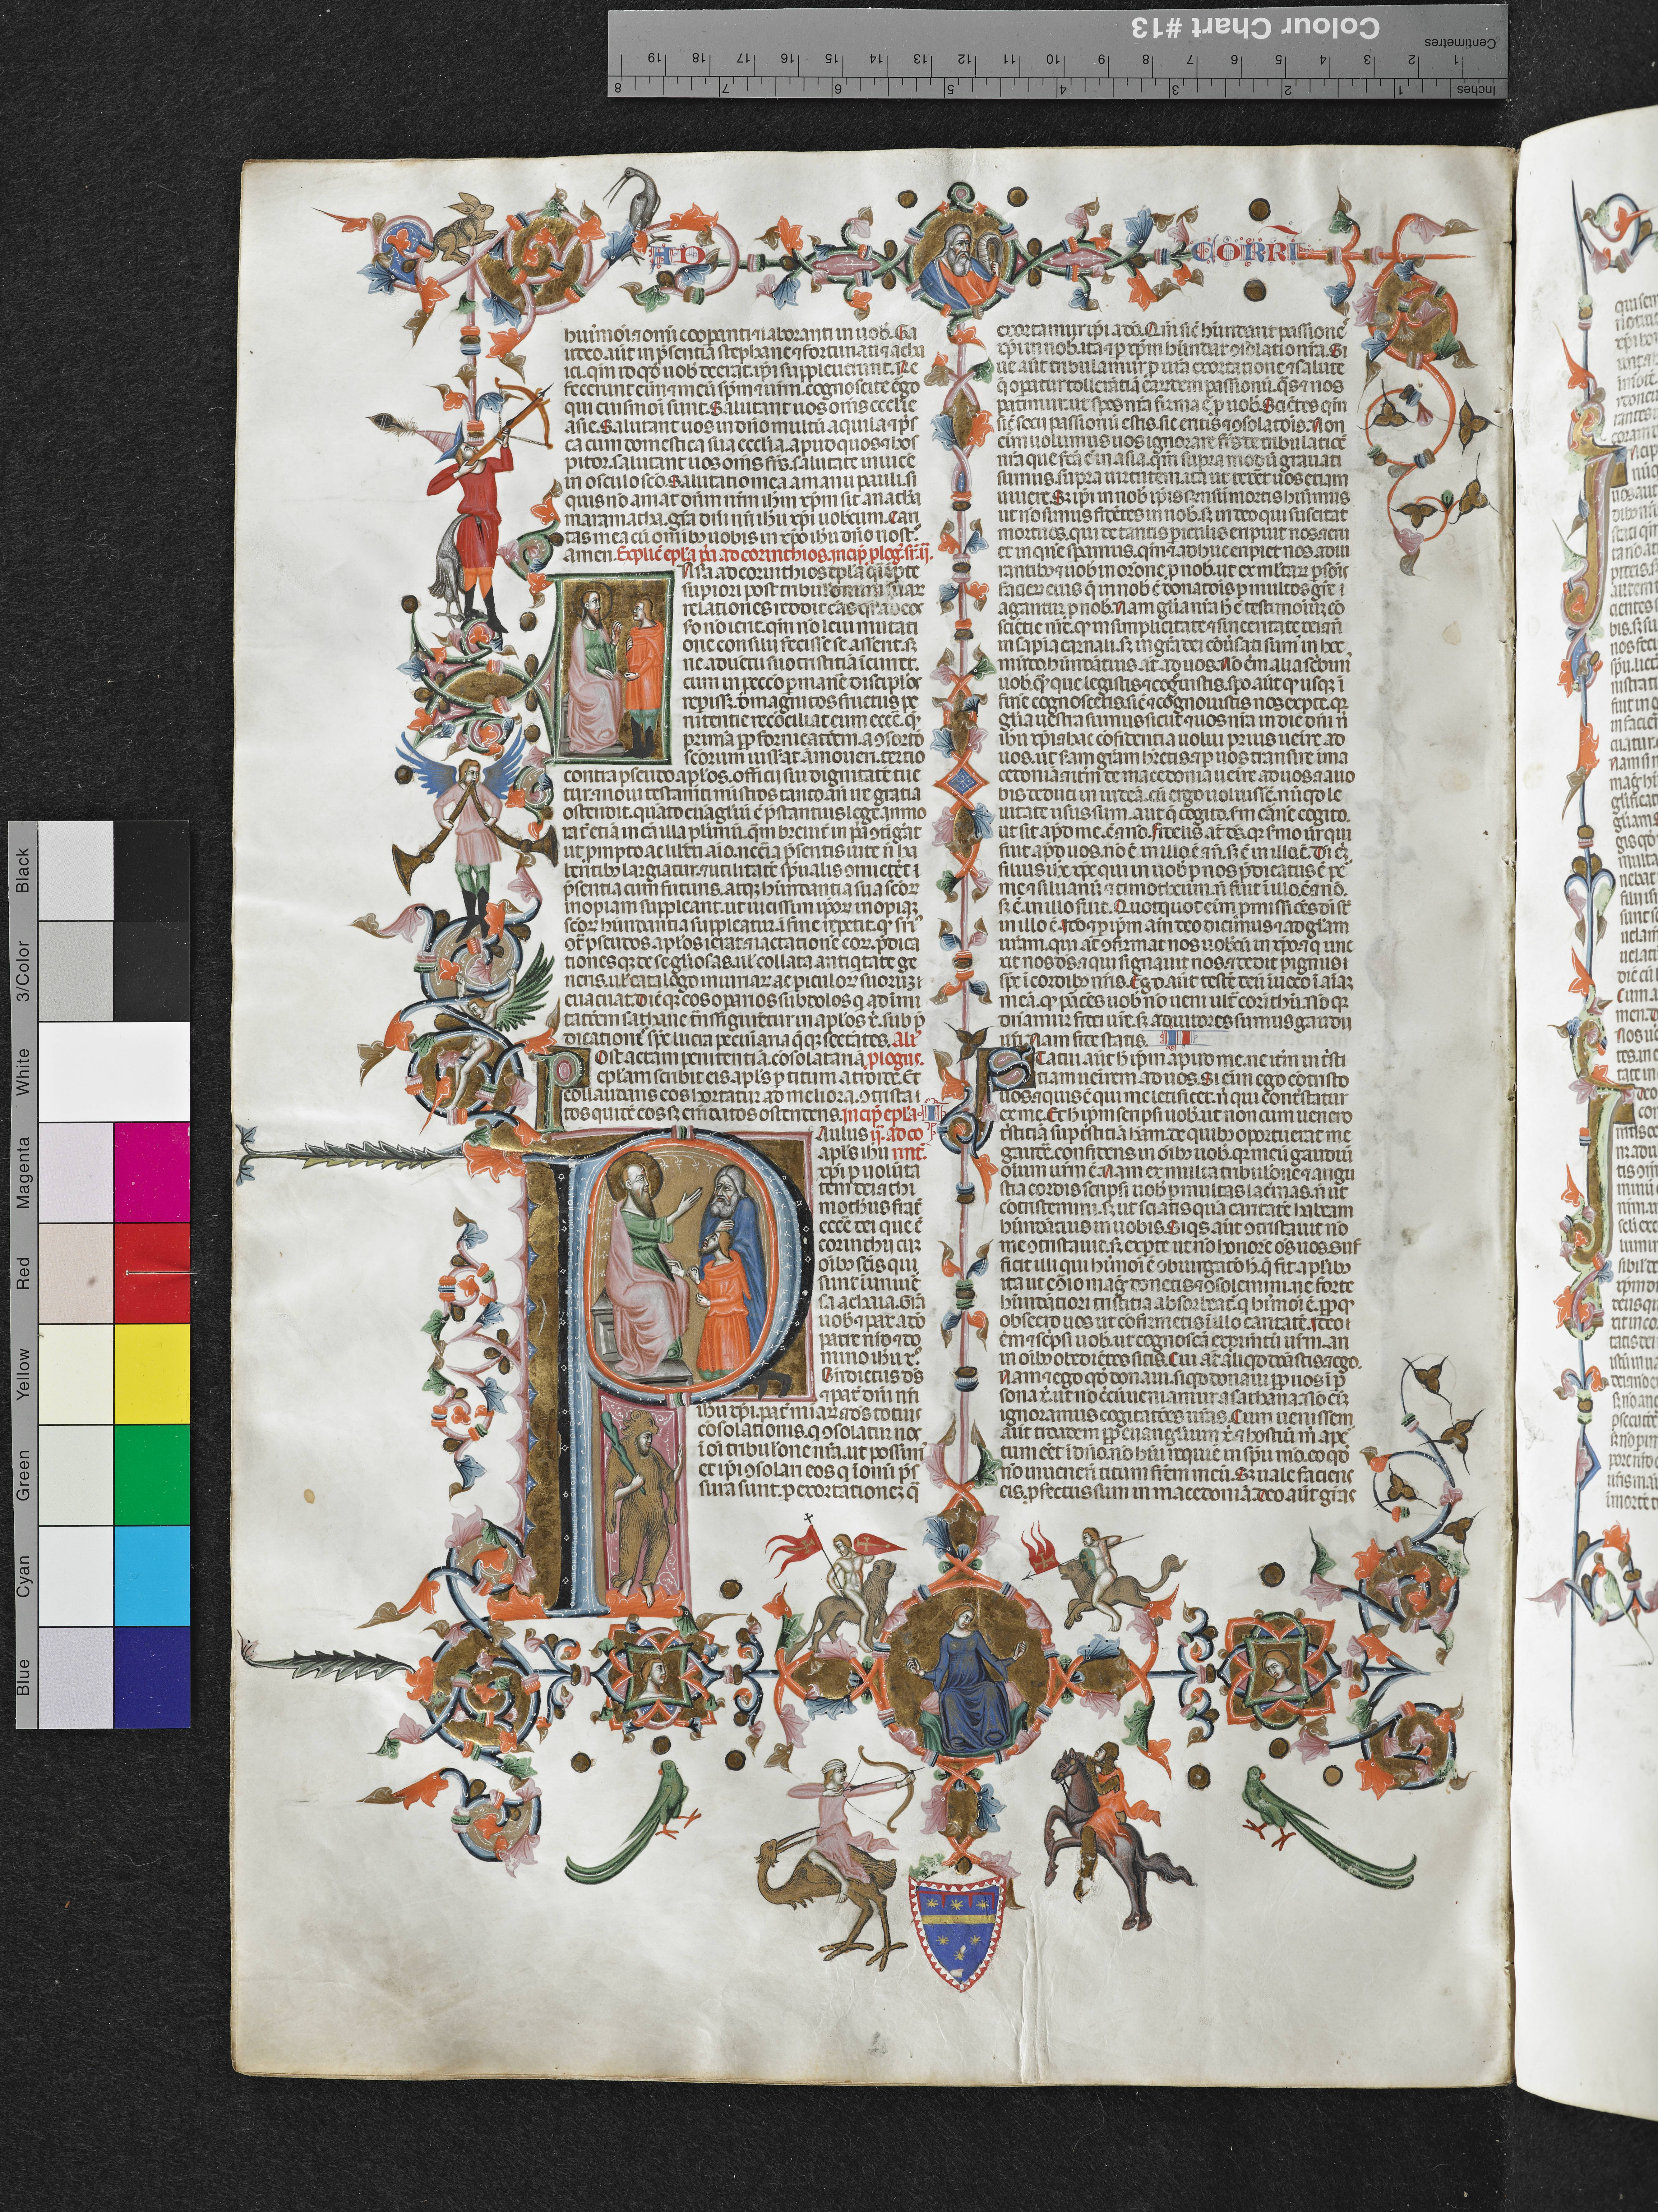

In [2]:
# import one image from scratch dir
folio_nr = '578'
test_im = glob.glob(scratch_dir + 'DATASET_2/IE3562253/REP3562255/*_{}_*.jpg'.format(folio_nr))[0]
display.Image(test_im)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2

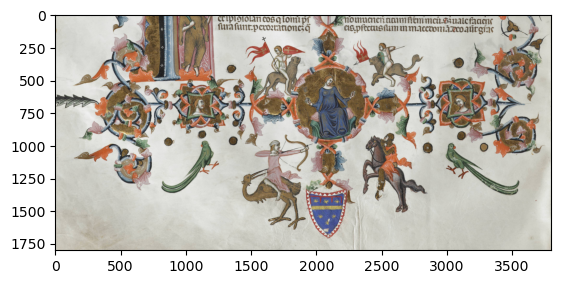

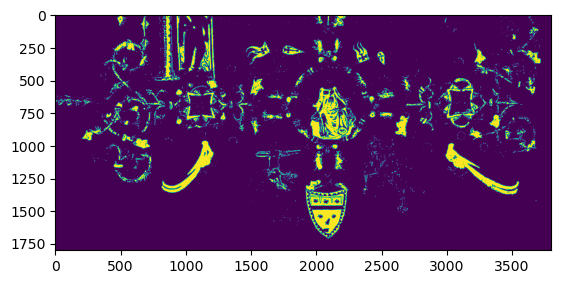

Red and green are present!


In [6]:
# reading image in cv2 and cropping it
img_bgr = cv2.imread(test_im)
im_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
# plt.imshow(im_rgb)
# # plt.rcParams["figure.figsize"] = (20,20)
# plt.show()

w_0, w_1 = 1000,4800
h_0, h_1 = 4700,6500

# w_0, w_1 = 320,2000
# h_0, h_1 = 250,2000

snip_RGB = im_rgb[h_0:h_1,w_0:w_1]
snip_BGR = img_bgr[h_0:h_1,w_0:w_1]
plt.imshow(snip_RGB)
plt.show()

img_hsv = cv2.cvtColor(snip_BGR, cv2.COLOR_BGR2HSV)
mask1 = cv2.inRange(img_hsv, (0,50,20), (5,255,255))
mask2 = cv2.inRange(img_hsv, (175,50,20), (180,255,255))
maskGreen = cv2.inRange(img_hsv, (36, 25, 25), (86, 255, 255))
maskBlue = cv2.inRange(img_hsv, (100, 50, 50), (130, 255, 255))
mask = cv2.bitwise_or(maskGreen, maskBlue)
mask = cv2.bitwise_or(cv2.bitwise_or(cv2.bitwise_or(mask1, mask2), maskGreen), maskBlue)
plt.imshow(mask)
plt.show()

if cv2.countNonZero(mask) > 0:
    print('Red and green are present!')
else:
    print('Red/Green is not present!')

In [11]:
import skimage.data
import selectivesearch
from skimage.io import imsave, imread

img = skimage.io.imread(test_im)
img = img[h_0:h_1,w_0:w_1]
print(img.shape)

(1800, 3800, 3)


Selective Search

https://github.com/AlpacaTechJP/selectivesearch

In [8]:
img_lbl, regions = selectivesearch.selective_search(img, scale=500, sigma=0.8, min_size=600) # min_size = 200 (letters)
print(len(regions))

/data/leuven/355/vsc35516/miniconda3/envs/envirods/lib/python3.10/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


1117


In [12]:
counter = 0
for i in regions:
    rect = i['rect']
    #size = i['size']
    #print(rect)
    #print(size)
    [X, Y, W, H] = rect
    buf = 200
    if X < buf or Y < buf:
        buf = 0
    # img_ss_rgb = img[Y:Y+H, X:X+W]
    img_ss_rgb = img[Y-buf:Y+H+buf, X-buf:X+W+buf]

    # Determine if the color exists on the image
    # set threshold for number of colored pixels > 300
    if cv2.countNonZero(mask[Y:Y+H, X:X+W]) > 300 and H > 300 and W > 300:
        counter+=1
        #print(cv2.countNonZero(mask[Y:Y+H, X:X+W]))
        # print('colors present!')
        
        # plt.imshow(mask[Y:Y+H, X:X+W])
        # plt.show()
        
        save_path = scratch_dir + 'output/SS/{}_X{}_Y{}_W{}_H{}.jpg'.format(folio_nr,rect[0],rect[1],rect[2],rect[3])
        # print(save_path)
        # fig = plt.figure(figsize=(4, 4))
        # plt.imshow(img_ss_rgb)
        # plt.show()
        imsave(save_path, img_ss_rgb)
    # else:
    #     print('no colors!')
    #     # plt.imshow(mask[Y:Y+H, X:X+W])
    #     # plt.show()
print('snips saved:',counter)

snips saved: 361


Background removal

In [9]:
import torch
from carvekit.api.high import HiInterface

/data/leuven/355/vsc35516/miniconda3/envs/envirods/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
for image_path in glob.glob(scratch_dir+'output/SS/{}*.jpg'.format(folio_nr)):
    # print(image_path)
    # img = cv2.imread(image_path)
    # im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # plt.imshow(im_rgb)
    # # plt.rcParams["figure.figsize"] = (20,20)
    # plt.show()
    interface = HiInterface(object_type="object",  # Can be "object" or "hairs-like". # object = tracer_b7
                            batch_size_seg=5,
                            batch_size_matting=1,
                            device='cuda' if torch.cuda.is_available() else 'cpu',
                            seg_mask_size=640,  # Use 640 for Tracer B7 and 320 for U2Net
                            matting_mask_size=2048,
                            trimap_prob_threshold=231,
                            trimap_dilation=30,
                            trimap_erosion_iters=5,
                            fp16=False)
    images_without_background = interface([image_path])
    wo_bg = images_without_background[0]
    wo_bg = wo_bg.crop(wo_bg.getbbox()) # remove empty pixels

    # save image to scratch
    # image_cropped_path = scratch_dir + 'output/background_removed/' + image_path.split('/')[-1][:-4] + '.png' # must be png to contain transparency information
    # print(image_cropped_path)
    # save image locally
    image_cropped_path = './snips/' + image_path.split('/')[-1][:-4] + '.png' 
    wo_bg.save(image_cropped_path)

    # reading image in cv2 and cropping it
    # img = cv2.imread(image_cropped_path)
    # im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # plt.imshow(im_rgb)
    # # plt.rcParams["figure.figsize"] = (20,20)
    # plt.show()

In [62]:
print(scratch_dir+'output/background_removed/')
# wo_bg_path = glob.glob(scratch_dir+'output/background_removed/{}_*.png'.format(folio_nr))
wo_bg_path = ['/scratch/leuven/355/vsc35516/output/background_removed/39_X1211_Y1223_W1094_H876.png',
'/scratch/leuven/355/vsc35516/output/background_removed/39_X1286_Y1457_W846_H504.png',
'/scratch/leuven/355/vsc35516/output/background_removed/39_X854_Y645_W461_H450.png',
'/scratch/leuven/355/vsc35516/output/background_removed/39_X1665_Y0_W1397_H1299.png',
'/scratch/leuven/355/vsc35516/output/background_removed/39_X1333_Y1457_W794_H504.png',
'/scratch/leuven/355/vsc35516/output/background_removed/39_X244_Y486_W309_H332.png',
'/scratch/leuven/355/vsc35516/output/background_removed/39_X1286_Y1457_W846_H580.png',
'/scratch/leuven/355/vsc35516/output/background_removed/39_X421_Y1090_W310_H659.png',
'/scratch/leuven/355/vsc35516/output/background_removed/39_X1665_Y639_W462_H572.png',
'/scratch/leuven/355/vsc35516/output/background_removed/39_X0_Y90_W351_H461.png',
'/scratch/leuven/355/vsc35516/output/background_removed/39_X2645_Y893_W568_H378.png',
'/scratch/leuven/355/vsc35516/output/background_removed/39_X3067_Y148_W408_H386.png',
'/scratch/leuven/355/vsc35516/output/background_removed/39_X762_Y493_W1139_H589.png',
'/scratch/leuven/355/vsc35516/output/background_removed/39_X138_Y0_W1571_H836.png',
'/scratch/leuven/355/vsc35516/output/background_removed/39_X762_Y566_W432_H461.png',
'/scratch/leuven/355/vsc35516/output/background_removed/39_X2093_Y646_W367_H440.png',
'/scratch/leuven/355/vsc35516/output/background_removed/39_X1274_Y1517_W312_H385.png',
'/scratch/leuven/355/vsc35516/output/background_removed/39_X3293_Y286_W483_H868.png',
'/scratch/leuven/355/vsc35516/output/background_removed/39_X2062_Y547_W469_H706.png',
'/scratch/leuven/355/vsc35516/output/background_removed/39_X564_Y636_W329_H483.png',
'/scratch/leuven/355/vsc35516/output/background_removed/39_X1579_Y492_W447_H807.png']
print(len(wo_bg_path))

/scratch/leuven/355/vsc35516/output/background_removed/
21


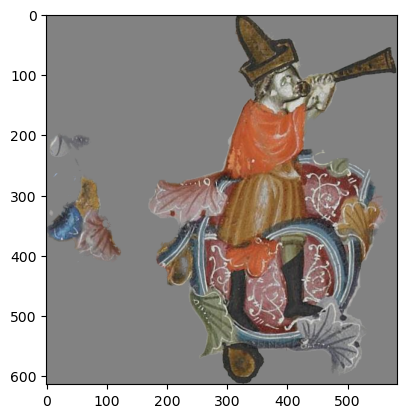

In [63]:
img_path = wo_bg_path[2]
img = cv2.imread(img_path)
im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(im_rgb)
# plt.rcParams["figure.figsize"] = (20,20)
plt.show()

In [64]:
# moving image from scratch to ManGO
suzanna_team_dir = home_dir + 'TEAM_2/output_suzanna'
session.data_objects.put(img_path, suzanna_team_dir + '/background_removed/' + image_path.split('/')[-1])

In [65]:
for image in wo_bg_path:
    session.data_objects.put(image, suzanna_team_dir + '/background_removed/' + image.split('/')[-1])